In [2]:
import pandas as pd
import numpy as np

from sklearn import preprocessing

# Data Science For Business Project

# Step 1

> Predict the category of each product, based on the reviewText field. View the problem as a multiclass classification (24 product categories).
>
> f(`reviewText`) -> category

## Preprocessing

In [3]:
# Load file (we keep the git repo as light as possible by only hosting the .gz's)
!rm -f *.json
!gunzip -c amazon_step1.json.gz > amazon_step1.json

# A first look at the data
df1 = pd.read_json('amazon_step1.json', lines=True)
df1.head()

,asin,category,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B000J4HXUC,Sports_and_Outdoors,"[1, 1]",5,It's a .50 Caliber Ammo Can. That largely sums...,"01 5, 2014",A3QRW0UJPKIAX7,Grant Fritchey,Clean and Exactly as Advertised,1388880000
1,0983393214,Books,"[0, 0]",5,This was a very good book. It kept me excited ...,"06 23, 2013",A2SEIOM4H06WTH,TJ,Great read!,1371945600
2,B003G4FVMY,Grocery_and_Gourmet_Food,"[0, 0]",5,"If you love coconut the way I do, you can't go...","05 19, 2013",A3GDEXMU9587JX,"K. Parsley ""kindlekat""","If you love coconut, get this coffee",1368921600
3,B00F9VRNF0,Cell_Phones_and_Accessories,"[0, 0]",5,I recently switched from the Galaxy S3 to the ...,"04 25, 2014",ASP3J2NEHDN4E,ChriS,Superior Protection!!!,1398384000
4,B00D5OZQUC,Amazon_Instant_Video,"[0, 0]",5,"Good show,looks like the gap from season 2 to ...","11 4, 2013",A1EDBI6TBKP9CO,Grants Book Trade,"Love the show, thanks for putting Season 3 on ...",1383523200


In [3]:
df1.dtypes

asin              object
category          object
helpful           object
overall            int64
reviewText        object
reviewTime        object
reviewerID        object
reviewerName      object
summary           object
unixReviewTime     int64
dtype: object

In [4]:
# Analyze the data: features and sample
num_total_samples = len(df1.index)
num_total_features = len(df1.columns)
print("Number of features:", num_total_features)
print("Number of samples:", num_total_samples)

Number of features: 10
Number of samples: 96000


In [5]:
# Start by counting the number of valid entrie per sample
num_valid_entries_per_sample = df1.count(axis=1)
# Then compute the total number of complete samples
num_complete_samples = num_valid_entries_per_sample.tolist().count(num_total_features)

# We can now compute the percenter of damaged sample
percentage_damaged_samples = 1 - num_complete_samples/num_total_samples
print('Number of damaged samples:', num_total_samples - num_complete_samples)
print('Percentage of damaged Samples:', np.around(100*percentage_damaged_samples,decimals=1), '%')

Number of damaged samples: 994
Percentage of damaged Samples: 1.0 %


It appears that we have some missing data. <br />
Let's see the number of valid entries for each feature

In [6]:
num_valid_entries_per_feature = df1.count(axis=0).sort_values()
print("Number of valid entrie perf feature: ")
print(num_valid_entries_per_feature)

Number of valid entrie perf feature: 
reviewerName      95006
asin              96000
category          96000
helpful           96000
overall           96000
reviewText        96000
reviewTime        96000
reviewerID        96000
summary           96000
unixReviewTime    96000
dtype: int64


Only `reviewerName` is sometimes missing (994 times to be precise). We will see how to deal with it later.

In [7]:
df1.isnull().sum()

asin                0
category            0
helpful             0
overall             0
reviewText          0
reviewTime          0
reviewerID          0
reviewerName      994
summary             0
unixReviewTime      0
dtype: int64

## We now present the preprocessing choices for each features

As stated in the project description, we will mainly rely on the **reviewText** feature. Nevertheless, we decide to take a look into each other feature and try to see if we can extract some useful information from them in order to help our models.

### asin
> Defintion: `amazon standard identification number which is unique for each product`

This feature will obvisously not bring useful information for the task we want to perform. We drop it. Another option would have been to use it as the index for each row, but we decided to go with the regular incremental index from pandas dataframe.

In [8]:
df1 = df1.drop(['asin'], axis=1)

### category
> Definition: `category of the product`

This is the target feature for part I of the project.<br />
We see below that the frequency of each category is equal<br />
This is a great news since we will be able to use a simple accuracy score to rank our different models.<br />
Moreover, it will be easy to sample a subset of the dataset if need be (e.g. to test a model on small data to improve speed).

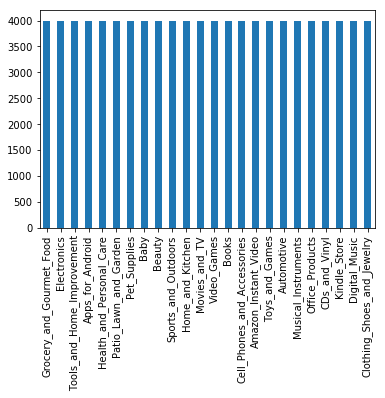

In [4]:
import matplotlib.pyplot as plt
df1["category"].value_counts().plot(kind='bar')
plt.show()

### helpful
> Definition: `[x,y]: x is the number of helpful ticks and y is the number of total ticks`

This features is not useful in it's actual form, but we think that we can take advantage of the information it contains. Indeed, it's reasonable to think that a five stars product might have a bigger ratio x/y than a one start product. Therefore, we decide to create a new feature from the *helpful* one: **helpfulPercentage**.

In [5]:
from ast import literal_eval
from sklearn.preprocessing import StandardScaler

# Compute the new feature 'helpfulPercentage'
def createHelpfulPercentage(df):
    # First, check if the column 'helpful' is a list or not. If not, convert it.
    if not isinstance(df.helpful[0], list):
        df.helpful = df.helpful.apply(literal_eval)
    df["helpfulPercentage"] = df.helpful.apply(lambda x: x[0]/x[1] if x[1] != 0 else 0)

createHelpfulPercentage(df1)
scalerHelpful = StandardScaler()
df1.helpfulPercentage = scalerHelpful.fit_transform(df1.helpfulPercentage.values.reshape(-1,1))

# Remove the 'old' one
df1 = df1.drop(["helpful"], axis=1)

df1.helpfulPercentage.sample(5)

53942   -0.751631
1204    -0.751631
64798   -0.751631
76628   -0.751631
22382    1.263339
Name: helpfulPercentage, dtype: float64

### overall
> Definition: `overal rating of the product in the range of [1,2,3,4,5]`

This is the target feature for parts II and II of the project

We can see that the mean for each category are quite close one to the other and except for the category *Apps_for_Android*, they are all above 4 (apprently, people rate products positevely...)

category
Amazon_Instant_Video           4.21125
Apps_for_Android               3.96325
Automotive                     4.45325
Baby                           4.22200
Beauty                         4.18700
Books                          4.26575
CDs_and_Vinyl                  4.27800
Cell_Phones_and_Accessories    4.12600
Clothing_Shoes_and_Jewelry     4.25000
Digital_Music                  4.22650
Electronics                    4.23575
Grocery_and_Gourmet_Food       4.25825
Health_and_Personal_Care       4.24675
Home_and_Kitchen               4.32525
Kindle_Store                   4.35850
Movies_and_TV                  4.12200
Musical_Instruments            4.49550
Office_Products                4.34450
Patio_Lawn_and_Garden          4.21875
Pet_Supplies                   4.22325
Sports_and_Outdoors            4.40150
Tools_and_Home_Improvement     4.35275
Toys_and_Games                 4.38350
Video_Games                    4.09725
Name: overall, dtype: float64


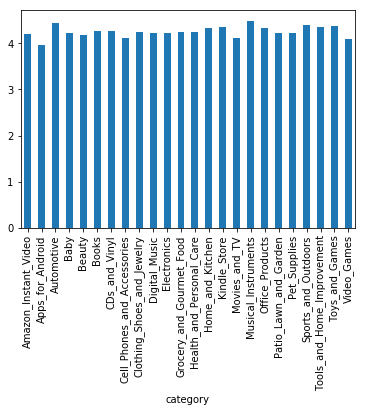

In [11]:
print(df1.groupby("category")["overall"].mean())

df1.groupby("category")["overall"].mean().plot(kind='bar')
plt.show()

### reviewText
> Definition: `text of the review`

This is the main feature on which we need to rely on. It's text, so we need to transform it into a numerical form.

But before doing so, we decided to extract some information from this feature.

Firstly, we create a new feature **reviewTextLenght**. The name describe perfectly the feature.

In [6]:
# Compute the feature
def createTextLength(df, feature):
    name = feature + "Length"
    df[name] = df[feature].apply(lambda x: len(x))
    df[name] = pd.to_numeric(df[name])
    
createTextLength(df1, "reviewText")

scalerTextLength = StandardScaler()
df1.reviewTextLength = scalerTextLength.fit_transform(df1.reviewTextLength.values.reshape(-1,1))

df1.reviewTextLength.sample(5)

/home/ra-danny/anaconda36/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


94539   -0.570267
46149    0.447081
67649    1.594042
58401    6.784717
24651   -0.522579
Name: reviewTextLength, dtype: float64

We also create features that capture the amount of punctuation that is used, namely *points*, *exclamation marks*, *question marks*, and *comas*. 

In [7]:
def count_char(row, char):
    return row.count(char)


def createTextPunctuationFeatures(df, feature):
    df[feature+"CountPoints"] = df[feature].apply(count_char, args=("."))
    df[feature+"CountExcl"] = df[feature].apply(count_char, args=("!"))
    df[feature+"CountInterr"] = df[feature].apply(count_char, args=("?"))
    df[feature+"CountComas"] = df[feature].apply(count_char, args=(","))

createTextPunctuationFeatures(df1, "reviewText")


# MinMaxScaler for all new features
scalerCountPoints = StandardScaler()
scalerCountExcl = StandardScaler()
scalerCountInterr = StandardScaler()
scalerCountComas = StandardScaler()

df1.rtCountPoints = scalerCountPoints.fit_transform(df1.reviewTextCountPoints.values.reshape(-1,1))
df1.rtCountExcl = scalerCountExcl.fit_transform(df1.reviewTextCountExcl.values.reshape(-1,1))
df1.rtCountInterr = scalerCountInterr.fit_transform(df1.reviewTextCountInterr.values.reshape(-1,1))
df1.rtCountComas = scalerCountComas.fit_transform(df1.reviewTextCountComas.values.reshape(-1,1))


# Output some sample
df1[["reviewTextCountPoints", "reviewTextCountExcl", "reviewTextCountInterr", "reviewTextCountComas"]].sample(5)

/home/ra-danny/anaconda36/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


,reviewTextCountPoints,reviewTextCountExcl,reviewTextCountInterr,reviewTextCountComas
1495,23,0,0,2
50420,0,0,0,0
20117,3,0,0,2
88645,1,0,0,0
41523,3,0,0,2


Another created features, that we think is useful to detect a sentiment in a text: presence of smileys in the text

In [8]:
def contains_smiley(df, feature):
    df[feature+"PositiveSmiley"] = df[feature].apply(lambda x: 1 * ((":)" in x) or (":D" in x) or (";)" in x) ))
    df[feature+"NegativeSmiley"] = df[feature].apply(lambda x: 1 * (":(" in x) )

contains_smiley(df1, "reviewText")

df1[["reviewTextPositiveSmiley", "reviewTextNegativeSmiley"]].sample(5)

,reviewTextPositiveSmiley,reviewTextNegativeSmiley
56529,0,0
17156,0,0
39300,0,0
62077,0,0
64737,0,0


In [9]:
def createALLCAPS(df, feature):
    def containsALLCAPSword(string):
        containsUpper = False
        for w in string.split(' '):
            if (w.isupper() and len(w)>3):
                containsUpper = True
                break
        return containsUpper
    df[feature+"AllCAPS"] = df[feature].apply(lambda x : containsALLCAPSword(x))

createALLCAPS(df1, "reviewText")

df1.reviewTextAllCAPS.sample(5)

63184     True
86257     True
87476    False
38412     True
95581    False
Name: reviewTextAllCAPS, dtype: bool

We decide to already buil the pipeline we will use to transform textual features into a numerical one.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from nltk.stem.snowball import EnglishStemmer

In [11]:
stemmer = EnglishStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

stop_words = 'english'

# We tokenize all the words, removing stop words (for english language) and then compute a TF-IDF score for each token
pipe_modified = Pipeline([('vectorize_stem', CountVectorizer(stop_words=stop_words,analyzer=stemmed_words, min_df=5, max_df=0.8)),
                          ('compute_tfidf', TfidfTransformer())])

### reviewTime
> Definition: `time of writing the review in normal format`

We think that we cannot retrieve useful information from this features. We decide to drop it.

In [18]:
df1 = df1.drop(["reviewTime"], axis=1)

### reviewerID
> Definition: `id of the reviewer`

We drop it also, no information that we can use.

In [19]:
df1 = df1.drop(['reviewerID'], axis=1)

> **A FAIRE SI ON A LE TEMPS**
>
>On peut imaginer qu'un user note seulement les produits d'une seule catégorie donc je pensais utiliser ça. Le seul moen que j'ai en tête est un peu tiré parles cheveux, donc je préfére le laisser de coté, si on a le temps on essaie, sinon on peut même le garder pour le présentation, si on a une question genre "What can you do to improve your work bla bla bla".
>
>L'idée serait de créer une feature par categorie pour chaque utilisateur qu'on a dans notre training data. La valeur de la features serait par exemple le pourcentage de parmis les produits que l'user a note, combien appartienne à cette catégorie

This one is a little more tricky. We can make the assumption that some people only rate negatively all products, so named "trolls", or that a persone only rate products for a given categorie. Therefore, we investigate it.
a = df1.groupby('reviewerID')['category'].apply(lambda x: list(x))

### reviewerName
> Definition: `name of the reviewer`

We decide to drop this feature, as it is redundant with the reviewerId (even if a reviewerID might be associated with multiples reviewerNames). Since we drop this feature, no need to taking care of the missing values.

In [20]:
df1 = df1.drop(["reviewerName"], axis=1)

### summary
> Defintion: `a summary of reviewer's opinion about the product`

Let's look at this feature, with the **reviewText** next to it.

In [21]:
df1[["reviewText", "summary"]]

,reviewText,summary
0,It's a .50 Caliber Ammo Can. That largely sums...,Clean and Exactly as Advertised
1,This was a very good book. It kept me excited ...,Great read!
2,"If you love coconut the way I do, you can't go...","If you love coconut, get this coffee"
3,I recently switched from the Galaxy S3 to the ...,Superior Protection!!!
4,"Good show,looks like the gap from season 2 to ...","Love the show, thanks for putting Season 3 on ..."
5,"I'm ordering more of these spoons, as one just...",Perfect for babies
6,We installed some sensor lights in the house f...,"Nice little sensor light, good for power fail..."
7,It was 1979 and the B-52s were on Saturday Nig...,Defining An Era
8,My Manchester terrier eats so fast she chokes ...,Perfect Solution For Dogs That Gobble Food Too...
9,This movie starts off with some clever and fun...,Reverse Cinderella just doesn't cut it.


As for the reviewText, we think that thise feature is really useful. We will be able to use the same pipeline as for `reviewText` to transform this feature to a numerical one.

### unixReviewTime
> Definition: `time of writing the review in UNIX format`

This feature is redudant with **reviewTime**. We also drop it.

In [22]:
df1 = df1.drop(["unixReviewTime"], axis=1)

## Preprocessing results
We give below an overview of the final data frame that we will be using.

In [23]:
df1.head()

,category,overall,reviewText,summary,helpfulPercentage,reviewTextLength,reviewTextCountPoints,reviewTextCountExcl,reviewTextCountInterr,reviewTextCountComas,reviewTextPositiveSmiley,reviewTextNegativeSmiley,reviewTextAllCAPS
0,Sports_and_Outdoors,5,It's a .50 Caliber Ammo Can. That largely sums...,Clean and Exactly as Advertised,1.561853,-0.106836,11,0,0,3,0,0,False
1,Books,5,This was a very good book. It kept me excited ...,Great read!,-0.751631,-0.627738,3,0,0,0,0,0,False
2,Grocery_and_Gourmet_Food,5,"If you love coconut the way I do, you can't go...","If you love coconut, get this coffee",-0.751631,-0.547035,1,1,0,1,0,0,False
3,Cell_Phones_and_Accessories,5,I recently switched from the Galaxy S3 to the ...,Superior Protection!!!,-0.751631,1.256557,18,4,0,2,0,0,True
4,Amazon_Instant_Video,5,"Good show,looks like the gap from season 2 to ...","Love the show, thanks for putting Season 3 on ...",-0.751631,-0.573936,2,0,2,3,0,0,False


## Training, tuning and testing of models

In [102]:
# The target feature --> CATEGORY
y = df1.category

In [103]:
# The features we will use
featuresToUse = ["helpfulPercentage", "reviewTextLength", "reviewTextCountPoints", "reviewTextCountExcl", "reviewTextCountInterr", "reviewTextCountComas"]

# Features we will not use : OVERALL

# Features to transfrom from textual to numerical representation: REVIEWTEXT and SUMMARY
# ---- ReviewText
pipe_modified.fit(df1.reviewText)
x_reviewText = pipe_modified.transform(df1.reviewText)

# ---- Summary
pipe_modified.fit(df1.summary)
x_summary = pipe_modified.transform(df1.summary)

In [104]:
# Now we can combine all features into a single dataframe
from scipy.sparse import hstack

# Combine first the two `sparse matrix` filled with the TF-IDF scores 
X = hstack((x_reviewText, x_summary))

In [27]:
### And then add the features we create in the pre-processing part
#for c in featuresToUse:
#    X = hstack((X,(df1[c])[:,None]))

In [28]:
X.shape

(96000, 26180)

In [105]:
# Now we divided the feature into two sets: a trainin set and another one for testing. 
# Training set = 80% of the entire data
# Testing set  = 20% of the entire data

from sklearn.cross_validation import train_test_split
seed = 2017
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [106]:
# Train
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)

# Test
print("X_test:  ", X_test.shape)
print("y_test:  ", y_test.shape)

X_train:  (76800, 26180)
y_train:  (76800,)
X_test:   (19200, 26180)
y_test:   (19200,)


In [13]:
# We define an helper function to compute and print the precision of our models
# Since we are dealing with a classifier, we decide to print only the 'precision? of the models
# Therefore, we don't use recall, f measure and support
def print_precision(y_t, y_pred):
    p_and_rec=precision_recall_fscore_support(y_t,y_pred)
    precision = p_and_rec[0]
    recall = p_and_rec[1]
    f_measure = p_and_rec[2]
    support = p_and_rec[3]
    print("Precision mean: ", np.mean(precision))

### Baseline model (Dummy Classifier)

In [14]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.dummy import DummyClassifier
baselineModel = DummyClassifier(random_state=seed)
baselineModel.fit(X_train,y_train)
y_pred = baselineModel.predict(X_test)

print_precision(y_test, y_pred)
print("1 / 24 = ", 1/24)

NameError: name 'X_train' is not defined

The baseline model has a precision that is close to 1/24. This is completly normal, since we have 24 features !

In [33]:
baseline_precision = 0.0447061846207

### Support Vector Model: Linear Support Vector Classification

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

# setup pipeline
estimators = []
estimators.append(('svm_clf', LinearSVC()))
pipe = Pipeline(estimators)

# tuning requsted parameter
tuned_parameters = [{'svm_clf__C': np.logspace(-5,15,11,base=2.0)}]
clf = GridSearchCV(pipe, tuned_parameters, cv=5, scoring='accuracy')

# Speed up computation: with only a subset of the training data for Grid search
subset_size = 10000
clf.fit(X_train[:subset_size],y_train[:subset_size])
clf.best_params_

NameError: name 'X_train' is not defined

In [35]:
# bect C value resulting from GridSearch
best_C = 0.5

In [36]:
svc = LinearSVC(C=best_C)
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)
print_precision(y_test, y_pred)

Precision mean:  0.753501105542


In [37]:
svc_precision = 0.762051884345

### Linear Model:  Stochastic Gradient Descent

In [16]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
parameters = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'alpha': [0.001, 0.0001, 0.00001, 0.000001]
}
cv = KFold(n_splits=10, random_state=seed)
sgd = GridSearchCV(SGDClassifier(loss="hinge", random_state=seed), parameters,
     scoring="accuracy", cv=cv)

# Takes approximately 15 minutes to run with our machines
runGridSearch = True
if (runGridSearch):
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_train, y_train, test_size=0.001, random_state=seed)
    X_train_s1, X_test_s1, y_train_s1, y_test_s1 = train_test_split(X_train_s, y_train_s, test_size=0.2, random_state=seed)
    sgd.fit(X_train_s1, y_train_s1)
    print("Best params:", sgd.best_estimator_.get_params())
else:
    # Copy/Paste from the results of the 'if' block
    print("Best params: {'alpha': 1e-05, 'average': False, 'class_weight': None, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, \
          'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'n_iter': 5, 'n_jobs': 1, 'penalty': 'l1', 'power_t': 0.5, 'random_state': 2017, 'shuffle': True, 'verbose': 0, 'warm_start': False}")

NameError: name 'X_train' is not defined

In [39]:
# Build the SGDClassifier with the best params return by grid search
sgd = SGDClassifier(alpha=1e-05, average=False, class_weight=None, epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15, learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1, penalty='l1', power_t=0.5, random_state=2017, shuffle= True, verbose=0, warm_start=False)

# Predict testing data
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)
print_precision(y_test, y_pred)

Precision mean:  0.734385828477


In [40]:
SGD_precision = 0.732781987884

### Similarity-based model: KNN Classifier

In [18]:
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV

In [17]:
from sklearn.neighbors import KNeighborsClassifier
estimators = []
estimators.append(('knn_clf', KNeighborsClassifier()))
knn_clf_pipe = Pipeline(estimators)
knn_clf_pipe.set_params(knn_clf__algorithm='brute')
knn_clf_pipe.set_params(knn_clf__weights='distance')

# create a grid search over n_neighbors values
# We decided to test from a large variety of neighbors possible. To speed up the computation time, we didn't test all possibilities, but use a step between each number
parameters = {
        'knn_clf__n_neighbors' : range(1,151,10)
}
estimator_knnclf = GridSearchCV(knn_clf_pipe, parameters, cv=5)

run = True
if run:
    # With our machines, we had several memory errors. Therefore we decide to use less data in order to have some results
    subset_size = 10000
    # evaluate the grid search and print best regressor
    estimator_knnclf.fit(X_train[:subset_size], y_train[:subset_size])
    print(estimator_knnclf.best_estimator_)
else:
    # Copy/Paste from the results of the 'if' block
    print("Pipeline(steps=[('knn_clf', KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',\
           metric_params=None, n_jobs=1, n_neighbors=61, p=2,\
           weights='uniform'))])")

NameError: name 'X_train' is not defined

In [43]:
# best number of neighbors obtained using GridSearchCV
best_clf_neighbors = 61

In [ ]:
# fix the number of neighbors to the best value
knn_clf_pipe.set_params(knn_clf__n_neighbors=best_clf_neighbors)

# fit the model to the training set
knn_clf_pipe.fit(X_train, y_train)

y_pred = knn_clf_pipe.predict(X_test[:1000])
print_precision(y_test[:1000], y_pred)

In [45]:
knn_precision = 0.470078407045

### Information Based model: Random Forest Classifier

In [107]:
tuned_parameters = {
    'n_estimators': range(1,801,100),
    'max_depth': range(1,101,20)
    }

rf_clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5, scoring='accuracy')

run = False
if run:
    # As for before, we need to use less data to avoid 'memory_errors'
    subset_size = 1000
    rf_clf.fit(X_train[:subset_size],y_train[:subset_size])
    print(rf_clf.best_params_)

{'max_depth': 41, 'n_estimators': 701}


In [109]:
tuned_parameters = {
    'n_estimators': range(602,801,30),
    'max_depth': range(32,51,5)
    }

rf_clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5, scoring='accuracy')

run = False
if run:
    # As for before, we need to use less data to avoid 'memory_errors'
    subset_size = 1000
    rf_clf.fit(X_train[:subset_size],y_train[:subset_size])
    print(rf_clf.best_params_)

{'max_depth': 42, 'n_estimators': 752}


In [117]:
best_n_estimators = 752
best_clf_tree_depth = 42

In [118]:
rf_clf = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_clf_tree_depth)

# As for before, we need to use less data to avoid 'memory_errors' and speed up the all computation
subset_size = 10000
rf_clf.fit(X_train[:subset_size],y_train[:subset_size])

y_pred = rf_clf.predict(X_test)
print_precision(y_test, y_pred)

Precision mean:  0.626824012941


In [ ]:
randomForest_precision = 0.627599048572

## Model comparison and best model
We rank our models by the accuracy it achieved with the test data.

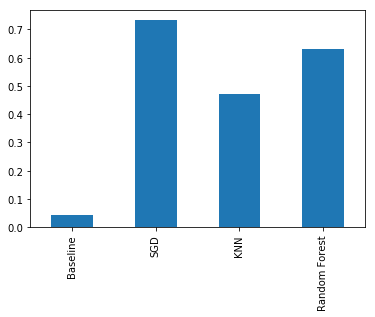

In [50]:
models_precision = [baseline_precision, SGD_precision, knn_precision, randomForest_precision]
models = ["Baseline", "SGD", "KNN", "Random Forest"]

models_df = pd.DataFrame(models_precision, models)
models_df[0].plot(kind='bar')
plt.show()

As we can see, the linear model achieved the higher accuracy with the test data.

## Prediction of the unseen data

In [51]:
# We will apply the same modification as for the preprocessing step for this new dataset

!gunzip -c amazon_step1_unseen.csv.gz > amazon_step1_unseen.csv
df1_unseen = pd.read_csv("amazon_step1_unseen.csv")

df1_unseen.sample(5)

,Unnamed: 0,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,label
1788,1788,A12PH6L5QSVTYN,0005119367,Im a product tester,"[0, 1]","I love the story of Joseph, it reminds me of m...",5.0,I can relate to Joseph In the Bible,1388016000,"12 26, 2013",?
6682,6682,A2RD94MPKMBLBJ,0912696591,A. Castillo,"[2, 2]",Absolutely loved this step by step instruction...,5.0,Wilton - who thought decorating was hard to do?,1374624000,"07 24, 2013",?
16325,16325,A2BN9DIBP9A0XG,1617160377,D. Vance,"[0, 0]",I was thrilled to get the Rosetta Stone and be...,5.0,Great tool!,1329696000,"02 20, 2012",?
22505,22505,A3PQ4BEV9GKI1C,0912696591,"Binta Tolbert ""DreadDIVA""","[0, 4]",This book is very helpful and useful for begin...,5.0,Helpful for beginners.,1235260800,"02 22, 2009",?
14224,14224,A380JIN0NF0PJZ,7293000960,nortiz,"[0, 0]",Do not buy system will tell you 6hrs remaing 1...,2.0,Wont last more thant 1 hour,1300060800,"03 14, 2011",?


In [52]:
# Verifiy if this data as null values
df1_unseen.isnull().sum()

Unnamed: 0         0
reviewerID         0
asin               0
reviewerName      90
helpful            0
reviewText         7
overall            0
summary            1
unixReviewTime     0
reviewTime         0
label              0
dtype: int64

Ah ! Compare to the training dataset, this validation data has some null values within two features of interest: `reviewText` and `summary`. 

We cannot drop those rows from our dataset: we need to predict the category of the product in a way ! We decide to replace some null entries by an empty string. For example, when the `reviewText` field is missing, we hope that the `summary`feature will be enough to predit the category.

In [53]:
df1_unseen.reviewText.fillna("", inplace=True)
df1_unseen.summary.fillna("", inplace=True)

# Assert that there is no more null values within this two features
df1_unseen.isnull().sum()

Unnamed: 0         0
reviewerID         0
asin               0
reviewerName      90
helpful            0
reviewText         0
overall            0
summary            0
unixReviewTime     0
reviewTime         0
label              0
dtype: int64

In [54]:
# Create the new features
#createHelpfulPercentage(df1_unseen)
#createTextLength(df1_unseen, "reviewText")
#createTextPunctuationFeatures(df1_unseen, "reviewText")

# Standardize with MinMaxScaler
#df1_unseen.helpfulPercentage             =    scalerHelpful.transform(     df1_unseen.helpfulPercentage.values.reshape(-1,1))
#df1_unseen.reviewTextLength              =    scalerTextLength.transform(  df1_unseen.reviewTextLength.values.reshape(-1,1))
#df1_unseen.reviewTextCountPoints         =    scalerCountPoints.transform( df1_unseen.reviewTextCountPoints.values.reshape(-1,1))
#df1_unseen.reviewTextCountExcl           =    scalerCountExcl.transform(   df1_unseen.reviewTextCountExcl.values.reshape(-1,1))
#df1_unseen.reviewTextCountInterr         =    scalerCountInterr.transform( df1_unseen.reviewTextCountInterr.values.reshape(-1,1))
#df1_unseen.reviewTextCountComas          =    scalerCountComas.transform(  df1_unseen.reviewTextCountComas.values.reshape(-1,1))

# Drop useless features
#df1_unseen = df1_unseen.drop(['asin', 'reviewTime', 'reviewerID', 'reviewerName', 'unixReviewTime', 'helpful'], axis=1)

# TF-IDF for 'reviewText'
pipe_modified.fit(df1.reviewText)
x_reviewText = pipe_modified.transform(df1_unseen.reviewText)

# TF-IDF for 'summary'
pipe_modified.fit(df1.summary)
x_summary = pipe_modified.transform(df1_unseen.summary)

# Merge all features into a single dataframe
X_unseen = hstack((x_reviewText, x_summary))
#featuresToUse = ["helpfulPercentage", "reviewTextLength", "rtCountPoints", "rtCountExcl", "rtCountInterr", "rtCountComas"]
#for c in featuresToUse:
#    X_unseen = hstack((X_unseen,(df1_unseen[c])[:,None]))

/home/ra-danny/anaconda36/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


KeyError: 'rtCountPoints'

In [ ]:
# SGD Classifier gives use the best prediction accuracy, we use it 
sgd = SGDClassifier(alpha=1e-05, average=False, class_weight=None, epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15, learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1, penalty='l1', power_t=0.5, random_state=2017, shuffle= True, verbose=0, warm_start=False)

# Now we can train it with the entire dataset !
sgd.fit(X, y)
y_unseen_pred = sgd.predict(X_unseen)

In [ ]:
# export the prediction into a file named "pred1.txt"
file = open('pred1.txt', 'w')
for item in y_unseen_pred:
  file.write("%s\n" % item)

# Step 2

> Predict whether a product review has 5 stars rating or not (yes/no), based on the reviewText field. The dataset for this step is filtered down to the Digital_Music category. Construct the problem as a binary classification (rank 5: 1, others: 0).
>
> `f(reviewText) -> overall (5 or not)` 

## Preprocessing

In [14]:
!gunzip -c amazon_step23.json.gz > amazon_step23.json
with open('amazon_step23.json') as f:
   content = f.readlines()

df2 = pd.read_json("".join(content), lines=True)
df2.sample(5)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
17773,B000002MUW,"[5, 5]",4,After the immense public backlash following th...,"08 15, 2005",A2DS532SLTFWFK,Det. Abilene,Another terrific disc,1124064000
27507,B00000FC5H,"[0, 0]",5,if you are looking for a nostalgic collection ...,"12 19, 2013",AJU9STZCDSWD,"Slow, Warm, Fuzzy Feeling",songs of my youth,1387411200
3386,B000001AJO,"[4, 4]",5,There's been a lot of debate over the years as...,"10 11, 2006",A70YTUFJY5HXN,Olukayode Balogun,Iconic Stevie,1160524800
61110,B005F6NA56,"[8, 106]",1,"Thank you, amazon, for providing samples of th...","10 4, 2011",A33RN6T49VEFUO,Dee J.,How did this drivel end up on a major label!,1317686400
44611,B0000TAZS8,"[0, 0]",1,50Cent has had quite a year&is still trying to...,"11 22, 2003",A9Q28YTLYREO7,"mistermaxxx08 ""mistermaxxx08""",Wack,1069459200


In [ ]:
df2.isnull().sum()

As for the preprocessing of step 1, there is only a few samples that have null values, all with the feature `reviewerName`. As discussed earlier, this is not problem for us.

In [15]:
# Create the new features
createHelpfulPercentage(df2)
createTextLength(df2, "reviewText")
createTextPunctuationFeatures(df2, "reviewText")
contains_smiley(df2, "reviewText")
createALLCAPS(df2, "reviewText")



# Standardize with MinMaxScaler
df2.helpfulPercentage     =    scalerHelpful.fit_transform(     df2.helpfulPercentage.values.reshape(-1,1))
df2.reviewTextLength      =    scalerTextLength.fit_transform(  df2.reviewTextLength.values.reshape(-1,1))
df2.reviewTextCountPoints         =    scalerCountPoints.fit_transform( df2.reviewTextCountPoints.values.reshape(-1,1))
df2.reviewTextCountExcl           =    scalerCountExcl.fit_transform(   df2.reviewTextCountExcl.values.reshape(-1,1))
df2.reviewTextCountInterr         =    scalerCountInterr.fit_transform( df2.reviewTextCountInterr.values.reshape(-1,1))
df2.reviewTextCountComas          =    scalerCountComas.fit_transform(  df2.reviewTextCountComas.values.reshape(-1,1))


# Drop useless features
df2 = df2.drop(['asin', 'reviewTime', 'reviewerID', 'reviewerName', 'unixReviewTime', 'helpful'], axis=1)

# TF-IDF for 'reviewText'
pipe_modified.fit(df2.reviewText)
x_reviewText = pipe_modified.transform(df2.reviewText)

# TF-IDF for 'summary'
pipe_modified.fit(df2.summary)
x_summary = pipe_modified.transform(df2.summary)

/home/ra-danny/anaconda36/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


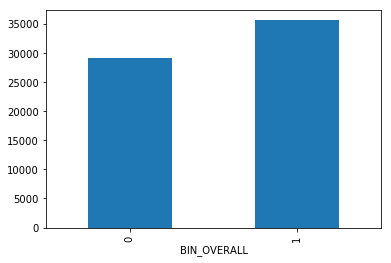

In [16]:
# Then we create BIN_OVERALL that is equal to 1 if rank is 5, and 0 otherwise
df2["BIN_OVERALL"] = 1 * (df2["overall"] == 5)
y = df2.BIN_OVERALL

# Plot the number of samples per class
df2.groupby("BIN_OVERALL").size().plot(kind='bar')
plt.show()

In [ ]:
# We can also make us of positive (http://ptrckprry.com/course/ssd/data/positive-words.txt) and
# negative (http://ptrckprry.com/course/ssd/data/negative-words.txt) word lists.
# For example, if a review contains only negative words, we guess the rating is not 5, and vice-versa
# We could also use the ratio good/(good + bad)
# TODO: what if the review contains negations (e.g. [...] not cool [...]) ?

df2.head()

Let's see which of the features we create seems to be the most useful. To do so, we will compute the mean for each of those features, dividing the dataset into two groups, based on the `BIN_OVERALL` feature.

In [ ]:
df_created_features = df2.groupby('BIN_OVERALL').mean()
df_created_features = df_created_features.drop(['overall', 'reviewTextPositiveSmiley', 'reviewTextNegativeSmiley', 'reviewTextAllCAPS'], axis=1)
df_created_features

In [ ]:
width = 0.35       # the width of the bars
fig, ax = plt.subplots()

ranking14 = df_created_features.as_matrix()[0]
ind = np.arange(len(ranking14))  # the x locations for the groups
rects1 = ax.bar(ind, ranking14, width, color='r')

ranking5 = df_created_features.as_matrix()[1]
rects2 = ax.bar(ind + width, ranking5, width, color='y')


# add some text for labels, title and axes ticks
ax.set_ylabel('Mean of values')
ax.set_title('Mean of the values (standardized) for the created features')
ax.set_xticks(ind)
ax.set_xticklabels(df_created_features.columns.tolist(), rotation=30)
ax.legend((rects1[0], rects2[0]), ('1-4 stars', '5 stars'))
plt.show()

The feature that we create from `helpful` seems do be very intersting. The number of exclamation (!) and interrogatoin (?) marks in the `reviewText` also seem to have a significant impact in the classification. On the other side, the length of the review and the number of point have fewer impact, but we can still see a small difference. We decided to keep all of this features for our classification models.

For the two smileys features, we can see below that the percentage of samples with a positive smiley is almost the same between the two classes. However, it is really different for negative smiley, where 5 stars ratings don't contain much. Even if the number of samples with negative smileys is low, we decided to keep this feature. For the `ALLCAPS` feature, it is the same deduction as for the `positiveSmiley` feature: we drop it too.

In [ ]:
total_nbr = df2.groupby("BIN_OVERALL").size()

print("-- Positive Smiley")
print("Percentage, per class, of samples with a positive smiley")
xx = df2[df2.reviewTextPositiveSmiley == 1].groupby("BIN_OVERALL").size()
print("1-4 ==> ", xx[0] / total_nbr[0], "%")
print("5   ==> ", xx[1] / total_nbr[1], "%")

print()

print("-- Negative Smiley")
print("Percentage, per class, of samples with a negative smiley")
xx = df2[df2.reviewTextNegativeSmiley == 1].groupby("BIN_OVERALL").size()
print("1-4 ==> ", xx[0] / total_nbr[0], "%")
print("5   ==> ", xx[1] / total_nbr[1], "%")

print()

print("-- ALL CAPS word")
print("Percentage, per class, of samples contains a words written in capital letters in the reviewText feature")
xx = df2[df2.reviewTextAllCAPS == 1].groupby("BIN_OVERALL").size()
print("1-4 ==> ", xx[0] / total_nbr[0], "%")
print("5   ==> ", xx[1] / total_nbr[1], "%")

In [17]:
# Let's compute the same features as we did for 'reviewText', but for the 'summary' feature this time !

# Create the new features
createTextLength(df2, "summary")
createTextPunctuationFeatures(df2, "summary")
contains_smiley(df2, "summary")
createALLCAPS(df2, "summary")


# Standardize with MinMaxScaler
summaryScalerTextLength   = StandardScaler()
summaryScalerCountPoint   = StandardScaler()
summaryScalerCountExcl    = StandardScaler()
summaryScalerCountInterr  = StandardScaler()
summaryScalerCountComas   = StandardScaler()

df2.summaryLength              =    summaryScalerTextLength.fit_transform(  df2.summaryLength.values.reshape(-1,1))
df2.summaryCountPoints         =    summaryScalerCountPoint.fit_transform( df2.summaryCountPoints.values.reshape(-1,1))
df2.summaryCountExcl           =    summaryScalerCountExcl.fit_transform(   df2.summaryCountExcl.values.reshape(-1,1))
df2.summaryCountInterr         =    summaryScalerCountInterr.fit_transform( df2.summaryCountInterr.values.reshape(-1,1))
df2.summaryCountComas          =    summaryScalerCountComas.fit_transform(  df2.summaryCountComas.values.reshape(-1,1))

/home/ra-danny/anaconda36/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


As for the `reviewText feature`, this features seems interesting. It is not a surprise that the length of the summary isn't usefull, but for the others ones, we decided to keep them.

In [ ]:
df_created_features = df2[["BIN_OVERALL", "summaryLength", "summaryCountPoints", "summaryCountExcl", "summaryCountInterr", "summaryCountComas"]]
df_created_features = df_created_features.groupby('BIN_OVERALL').mean()


width = 0.35       # the width of the bars
fig, ax = plt.subplots()

ranking14 = df_created_features.as_matrix()[0]
ind = np.arange(len(ranking14))  # the x locations for the groups
rects1 = ax.bar(ind, ranking14, width, color='r')

ranking5 = df_created_features.as_matrix()[1]
rects2 = ax.bar(ind + width, ranking5, width, color='y')


# add some text for labels, title and axes ticks
ax.set_ylabel('Mean of values')
ax.set_title('Mean of the values (standardized) for the created features')
ax.set_xticks(ind)
ax.set_xticklabels(df_created_features.columns.tolist(), rotation=50)
ax.legend((rects1[0], rects2[0]), ('1-4 stars', '5 stars'))
plt.show()

For the two smileys features, `summaryPositiveSmiley` and `summaryNegativeSmiley` aren't present in a lot of samples to considering it useful for something. For the feature `summaryAllCAPS`, we consider that the difference between the two classes isn't that big to keep the feature.

In [ ]:
total_nbr = df2.groupby("BIN_OVERALL").size()

print("-- Positive Smiley")
print("Percentage, per class, of samples with a positive smiley")
xx = df2[df2.summaryPositiveSmiley == 1].groupby("BIN_OVERALL").size()
print("1-4 ==> ", xx[0] / total_nbr[0], "%")
print("5   ==> ", xx[1] / total_nbr[1], "%")

print()

print("-- Negative Smiley")
print("Percentage, per class, of samples with a negative smiley")
xx = df2[df2.summaryNegativeSmiley == 1].groupby("BIN_OVERALL").size()
print("1-4 ==> ", xx[0] / total_nbr[0], "%")
print("5   ==> ", 0, "%")

print()

print("-- ALL CAPS word")
print("Percentage, per class, of samples contains a words written in capital letters in the reviewText feature")
xx = df2[df2.summaryAllCAPS == 1].groupby("BIN_OVERALL").size()
print("1-4 ==> ", xx[0] / total_nbr[0], "%")
print("5   ==> ", xx[1] / total_nbr[1], "%")

In [87]:
# Merge all features into a single dataframe
X2 = hstack((x_reviewText, x_summary))
featuresToUse = ["helpfulPercentage", "reviewTextLength", "reviewTextCountPoints", "reviewTextCountExcl", "reviewTextCountInterr", "reviewTextCountComas", "reviewTextNegativeSmiley", \
                "summaryCountPoints", "summaryCountExcl", "summaryCountInterr", "summaryCountComas"]
for c in featuresToUse:
    X2 = hstack((X2,(df2[c])[:,None]))

In [88]:
y = df2.BIN_OVERALL

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=seed)

# Train
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)

# Test
print("X_test:  ", X_test.shape)
print("y_test:  ", y_test.shape)

X_train:  (51764, 26523)
y_train:  (51764,)
X_test:   (12942, 26523)
y_test:   (12942,)


### Baseline model

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.dummy import DummyClassifier
baselineModel = DummyClassifier(random_state=seed)
baselineModel.fit(X_train,y_train)
y_pred = baselineModel.predict(X_test)

print_precision(y_test, y_pred)

In [ ]:
baseline_precision = 0.501699828321

### Support Vector Model: Linear Support Vector Classification

In [ ]:
from sklearn.svm import LinearSVC
classifier_rbf = LinearSVC()
classifier_rbf.fit(X_train, y_train)


from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

# setup pipeline
estimators = []
estimators.append(('svm_clf', LinearSVC()))
pipe = Pipeline(estimators)

# tuning requsted parameter
tuned_parameters = [{'svm_clf__C': np.logspace(-5,15,11,base=2.0)}]
clf = GridSearchCV(pipe, tuned_parameters, cv=5, scoring='accuracy')

# Speed up computation: with only a subset of the training data for Grid search
subset_size = 5000
clf.fit(X_train[:subset_size],y_train[:subset_size])
clf.best_params_

In [ ]:
# bect C value resulting from GridSearch
best_C = 0.5

In [ ]:
svc = LinearSVC(C=best_C)
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)
print_precision(y_test, y_pred)

In [ ]:
svc_precision = 0.766898937707

### Linear Model:  Stochastic Gradient Descent

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
parameters = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'alpha': [0.001, 0.0001, 0.00001, 0.000001]
}
cv = KFold(n_splits=10, random_state=seed)
sgd = GridSearchCV(SGDClassifier(loss="hinge", random_state=seed), parameters,
     scoring="accuracy", cv=cv)

runGridSearch = True
if (runGridSearch):
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_train, y_train, test_size=0.001, random_state=seed)
    X_train_s1, X_test_s1, y_train_s1, y_test_s1 = train_test_split(X_train_s, y_train_s, test_size=0.2, random_state=seed)
    sgd.fit(X_train_s1, y_train_s1)
    print("Best params:", sgd.best_estimator_.get_params())
else:
    # Copy/Paste from the results of the 'if' block
    print("Best params: {'alpha': 0.0001, 'average': False, 'class_weight': None, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True,\
          'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'n_iter': 5, 'n_jobs': 1, 'penalty': 'elasticnet', 'power_t': 0.5, 'random_state': 2017, 'shuffle': True, 'verbose': 0, 'warm_start': False}")

In [ ]:
# Build the SGDClassifier with the best params return by grid search
sgd = SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15, learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1, penalty='elasticnet',
                    power_t= 0.5, random_state=2017, shuffle=True, verbose=0, warm_start=False)

# Predict testing data
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)
print_precision(y_test, y_pred)

In [ ]:
SGD_precision = 0.76804551793

### Similarity-based model: KNN Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
estimators = []
estimators.append(('knn_clf', KNeighborsClassifier()))
knn_clf_pipe = Pipeline(estimators)
knn_clf_pipe.set_params(knn_clf__algorithm='brute')
knn_clf_pipe.set_params(knn_clf__weights='distance')

# create a grid search over n_neighbors values
# We decided to test from a large variety of neighbors possible. To speed up the computation time, we didn't test all possibilities, but use a step between each number
parameters = {
        'knn_clf__n_neighbors' : range(1,151,10)
}
estimator_knnclf = GridSearchCV(knn_clf_pipe, parameters, cv=5)

run = True
if run:
    # With our machines, we had several memory errors. Therefore we decide to use less data in order to have some results
    subset_size = 10000
    # evaluate the grid search and print best regressor
    estimator_knnclf.fit(X_train[:subset_size], y_train[:subset_size])
    print(estimator_knnclf.best_estimator_)
else:
    # Copy/Paste from the results of the 'if' block
    print("Pipeline(steps=[('knn_clf', KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',\
           metric_params=None, n_jobs=1, n_neighbors=71, p=2,\
           weights='uniform'))])")

In [ ]:
# best number of neighbors obtained using GridSearchCV
best_clf_tree_neighbors = 71

In [ ]:
# fix the number of neighbors to the best value
knn_clf_pipe.set_params(knn_clf__n_neighbors=best_clf_tree_neighbors)

# fit the model to the training set
knn_clf_pipe.fit(X_train, y_train)

subset_size = 2000
y_pred = knn_clf_pipe.predict(X_test[:subset_size])
print_precision(y_test[:subset_size], y_pred)

In [ ]:
knn_precision = 0.633343629488859764895741

### Information Based model: Random Forest Classifier

In [98]:
tuned_parameters = {
    'n_estimators': range(1,801,100),
    'max_depth': range(1,101,20)
    }

rf_clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5, scoring='accuracy')

run = True
if run:
    # As for before, we need to use less data to avoid 'memory_errors'
    subset_size = 1000
    rf_clf.fit(X_train[:subset_size],y_train[:subset_size])
    print(rf_clf.best_params_)

{'max_depth': 41, 'n_estimators': 501}


In [99]:
tuned_parameters = {
    'n_estimators': range(492,511,5),
    'max_depth': range(32,51,3)
    }

rf_clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5, scoring='accuracy')

run = True
if run:
    # As for before, we need to use less data to avoid 'memory_errors'
    subset_size = 1000
    rf_clf.fit(X_train[:subset_size],y_train[:subset_size])
    print(rf_clf.best_params_)

{'max_depth': 32, 'n_estimators': 507}


In [100]:
best_n_estimators = 507
best_clf_tree_depth = 32

In [101]:
rf_clf = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_clf_tree_depth)

# As for before, we need to use less data to avoid 'memory_errors' and speed up the all computation
subset_size = 10000
rf_clf.fit(X_train[:subset_size],y_train[:subset_size])

y_pred = rf_clf.predict(X_test)
print_precision(y_test, y_pred)

Precision mean:  0.759069142108


In [ ]:
randomForest_precision = 0.759069142108

## Model comparison

In [ ]:
models_precision

In [ ]:
models_precision = [baseline_precision, svc_precision, SGD_precision, knn_precision, randomForest_precision]
models = ["Baseline", "SVC", "SGD", "KNN", "Random Forest"]

models_df = pd.DataFrame(models_precision, models)
models_df[0].plot(kind='bar')
plt.show()

## Prediction of the unseen data

In [ ]:
# We will apply the same modification as for the preprocessing step for this new dataset

!gunzip -c amazon_step1_unseen.csv.gz > amazon_step1_unseen.csv
df2_unseen = pd.read_csv("amazon_step2_unseen.csv")

df2_unseen.sample(5)

In [ ]:
# Verifiy if this data as null values
df2_unseen.isnull().sum()

In [ ]:
# Create the new features
createHelpfulPercentage(df2_unseen)
createTextLength(df2_unseen, "reviewText")
createTextPunctuationFeatures(df2_unseen, "reviewText")
contains_smiley(df2_unseen, "reviewText")
createALLCAPS(df2_unseen, "reviewText")
createTextLength(df2_unseen, "summary")
createTextPunctuationFeatures(df2_unseen, "summary")
contains_smiley(df2_unseen, "summary")
createALLCAPS(df2_unseen, "summary")


# Standardize with MinMaxScaler
df2_unseen.helpfulPercentage          =    scalerHelpful.transform(     df2_unseen.helpfulPercentage.values.reshape(-1,1))
df2_unseen.reviewTextLength           =    scalerTextLength.transform(  df2_unseen.reviewTextLength.values.reshape(-1,1))
df2_unseen.reviewTextCountPoints      =    scalerCountPoints.transform( df2_unseen.reviewTextCountPoints.values.reshape(-1,1))
df2_unseen.reviewTextCountExcl        =    scalerCountExcl.transform(   df2_unseen.reviewTextCountExcl.values.reshape(-1,1))
df2_unseen.reviewTextCountInterr      =    scalerCountInterr.transform( df2_unseen.reviewTextCountInterr.values.reshape(-1,1))
df2_unseen.reviewTextCountComas       =    scalerCountComas.transform(  df2_unseen.reviewTextCountComas.values.reshape(-1,1))
df2_unseen.summaryLength              =    summaryScalerTextLength.transform(  df2_unseen.summaryLength.values.reshape(-1,1))
df2_unseen.summaryCountPoints         =    summaryScalerCountPoint.transform( df2_unseen.summaryCountPoints.values.reshape(-1,1))
df2_unseen.summaryCountExcl           =    summaryScalerCountExcl.transform(   df2_unseen.summaryCountExcl.values.reshape(-1,1))
df2_unseen.summaryCountInterr         =    summaryScalerCountInterr.transform( df2_unseen.summaryCountInterr.values.reshape(-1,1))
df2_unseen.summaryCountComas          =    summaryScalerCountComas.transform(  df2_unseen.summaryCountComas.values.reshape(-1,1))

# TF-IDF for 'reviewText'
pipe_modified.fit(df2.reviewText)
x_reviewText = pipe_modified.transform(df2_unseen.reviewText)

# TF-IDF for 'summary'
pipe_modified.fit(df2.summary)
x_summary = pipe_modified.transform(df2_unseen.summary)

# Merge all features into a single dataframe
X_unseen = hstack((x_reviewText, x_summary))
featuresToUse = ["helpfulPercentage", "reviewTextLength", "reviewTextCountPoints", "reviewTextCountExcl", "reviewTextCountInterr", "reviewTextCountComas", "reviewTextNegativeSmiley", \
                "summaryCountPoints", "summaryCountExcl", "summaryCountInterr", "summaryCountComas"]
for c in featuresToUse:
    X_unseen = hstack((X_unseen,(df2_unseen[c])[:,None]))

In [ ]:
# Build the SGDClassifier with the best params return by grid search
sgd = SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15, learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1, penalty='elasticnet',
                    power_t= 0.5, random_state=2017, shuffle=True, verbose=0, warm_start=False)

# Predict testing data
sgd.fit(X2, y)
y_unseen_pred = sgd.predict(X_unseen)

In [ ]:
# export the prediction into a file named "pred2.txt"
file = open('pred2.txt', 'w')
for item in y_unseen_pred:
  file.write("%s\n" % item)

# Step 3

> Predict the actual number of stars, based on the reviewText field. Again, the dataset for this step is filtered down to the Digital_Music category. Construct the problem as a multiclass classification (5 categories labeled from 1 to 5).
>
> `f(reviewText) -> overall`

## Preprocessing

In [18]:
# We use exactly the same preprocessing as for `step 2`
df3 = df2.copy(deep=True)
df3.sample(5)

,overall,reviewText,summary,helpfulPercentage,reviewTextLength,reviewTextCountPoints,reviewTextCountExcl,reviewTextCountInterr,reviewTextCountComas,reviewTextPositiveSmiley,...,reviewTextAllCAPS,BIN_OVERALL,summaryLength,summaryCountPoints,summaryCountExcl,summaryCountInterr,summaryCountComas,summaryPositiveSmiley,summaryNegativeSmiley,summaryAllCAPS
57908,5,"This is simply an incredible, amazing piece of...",Beauty beyond tears,-1.224579,3.018652,3.134017,0.026761,5.368781,7.205101,0,...,True,1,-0.571582,-0.343490,-0.242413,-0.144688,-0.316271,0,0,False
23009,5,"With solid production,World wide anthems,and t...",2 albums 2 classics 100% is hard to top,1.136323,-0.698586,-0.334815,0.026761,1.570981,0.093481,0,...,False,1,0.657786,-0.343490,-0.242413,-0.144688,-0.316271,0,0,False
25517,4,A great band who knows how to rock hard. With...,I can hear dead people singing.,-1.224579,-0.892116,-0.797326,-0.320319,-0.327919,-0.860517,0,...,False,0,0.166039,0.306199,-0.242413,-0.144688,-0.316271,0,0,False
8977,4,"Cyndi Lauper followed up the blockbuster ""She'...",The Before and After review,-0.044128,0.040845,-0.103560,-0.320319,-0.327919,0.093481,0,...,False,0,-0.079835,-0.343490,-0.242413,-0.144688,-0.316271,0,0,False
25615,5,This is one of Dan's best albums.Yes it's heav...,"Hey,There's Steely Dan!",1.136323,-0.349867,-0.720241,0.026761,-0.327919,-0.340154,1,...,False,1,-0.325709,-0.343490,0.552276,-0.144688,2.221507,0,0,False


In [19]:
# The output for part 2 isn't applicable here
df3 = df3.drop(['BIN_OVERALL'], axis=1)

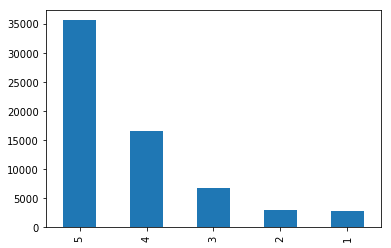

In [20]:
df3.overall.value_counts().plot(kind='bar')
plt.show()

In [21]:
df_created_features = df3.groupby('overall').mean()
df_created_features = df_created_features.drop(['reviewTextPositiveSmiley', 'reviewTextNegativeSmiley', 'reviewTextAllCAPS', 'summaryPositiveSmiley', 'summaryNegativeSmiley', 'summaryAllCAPS', ], axis=1)
df_created_features

,helpfulPercentage,reviewTextLength,reviewTextCountPoints,reviewTextCountExcl,reviewTextCountInterr,reviewTextCountComas,summaryLength,summaryCountPoints,summaryCountExcl,summaryCountInterr,summaryCountComas
overall,,,,,,,,,,,
1,-0.335824,-0.376946,-0.246240,0.134205,0.394289,-0.329403,-0.111395,0.091576,0.086169,0.370742,-0.022576
2,-0.340399,-0.128550,-0.047065,-0.081976,0.228819,-0.125382,-0.069318,0.101795,-0.128622,0.278558,0.053857
3,-0.247434,0.051797,0.053358,-0.159637,0.078209,0.057405,0.027809,0.072123,-0.158016,0.061875,0.137905
4,0.011647,0.110114,0.068740,-0.089100,-0.026594,0.107222,0.038150,0.005321,-0.092279,-0.042961,0.049141
5,0.096940,-0.020616,-0.018831,0.068278,-0.052850,-0.024339,-0.008435,-0.032030,0.077160,-0.044488,-0.051937


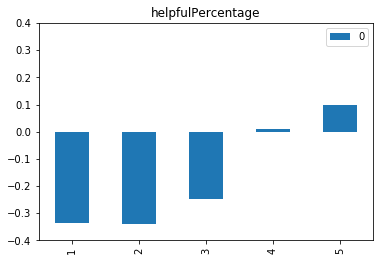

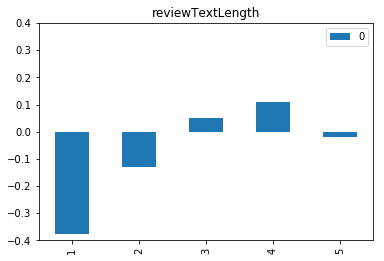

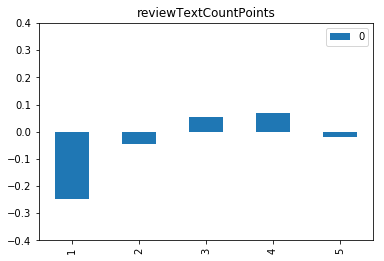

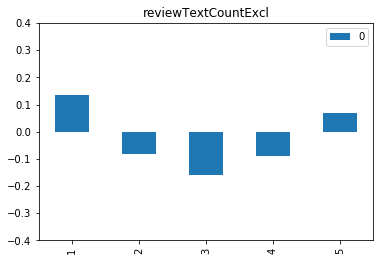

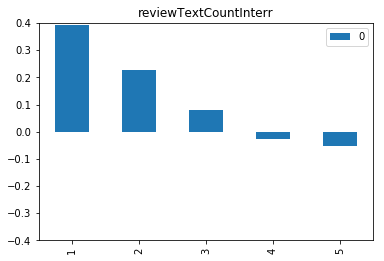

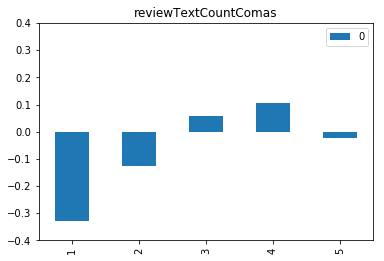

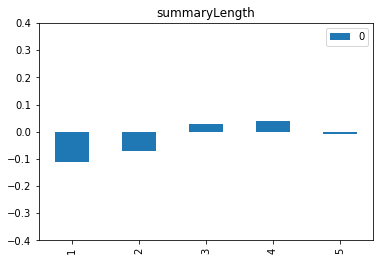

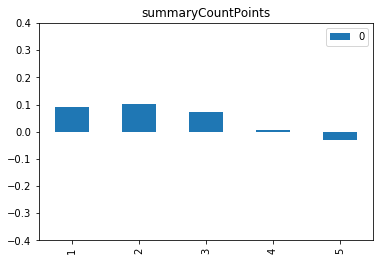

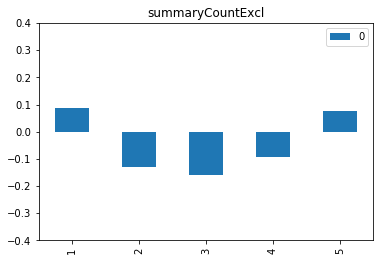

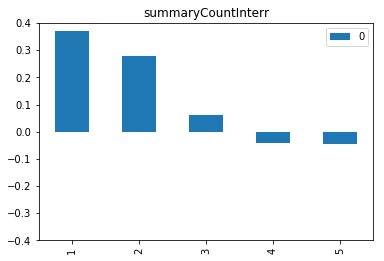

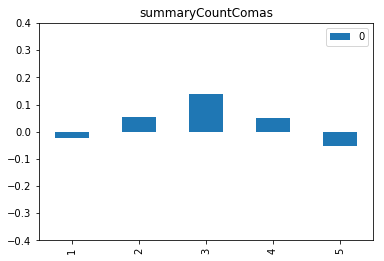

In [22]:
for x in df_created_features:
    mean_values = df_created_features[x].values
    overall = ["1", "2", "3", "4", "5"]
    
    mvalues_df = pd.DataFrame(mean_values, overall)
    mvalues_df.plot(kind='bar')
    
    plt.title(x)
    plt.ylim([-0.4, 0.4])
    plt.show()

In [69]:
xx = df3[df3.summaryPositiveSmiley == 1].groupby("overall").size()
xx

overall
2     1
3     2
4    10
5    30
dtype: int64

In [92]:
total_nbr = df3.groupby("overall").size()

print("-- Positive Smiley")
print("Percentage, per class, of samples with a positive smiley")
xx = df3[df3.reviewTextPositiveSmiley == 1].groupby("overall").size()
for i in range(1,6):
    if i not in xx:
        xx[i] = 0
print("1 ==> ", xx[1] / total_nbr[1], "%")
print("2 ==> ", xx[2] / total_nbr[2], "%")
print("3 ==> ", xx[3] / total_nbr[3], "%")
print("4 ==> ", xx[4] / total_nbr[4], "%")
print("5 ==> ", xx[5] / total_nbr[5], "%")

print()

print("-- Negative Smiley")
print("Percentage, per class, of samples with a negative smiley")
xx = df3[df3.reviewTextNegativeSmiley == 1].groupby("overall").size()
for i in range(1,6):
    if i not in xx:
        xx[i] = 0
print("1 ==> ", xx[1] / total_nbr[1], "%")
print("2 ==> ", xx[2] / total_nbr[2], "%")
print("3 ==> ", xx[3] / total_nbr[3], "%")
print("4 ==> ", xx[4] / total_nbr[4], "%")
print("5 ==> ", xx[5] / total_nbr[5], "%")

print()

print("-- ALL CAPS word")
print("Percentage, per class, of samples contains a words written in capital letters in the reviewText feature")
xx = df3[df3.reviewTextAllCAPS == 1].groupby("overall").size()
for i in range(1,6):
    if i not in xx:
        xx[i] = 0
print("1 ==> ", xx[1] / total_nbr[1], "%")
print("2 ==> ", xx[2] / total_nbr[2], "%")
print("3 ==> ", xx[3] / total_nbr[3], "%")
print("4 ==> ", xx[4] / total_nbr[4], "%")
print("5 ==> ", xx[5] / total_nbr[5], "%")

-- Positive Smiley
Percentage, per class, of samples with a positive smiley
1 ==>  0.00967395198853 %
2 ==>  0.0136212624585 %
3 ==>  0.0219472676388 %
4 ==>  0.0274552491534 %
5 ==>  0.0235244519393 %

-- Negative Smiley
Percentage, per class, of samples with a negative smiley
1 ==>  0.00322465066284 %
2 ==>  0.00199335548173 %
3 ==>  0.00103107968773 %
4 ==>  0.000665215287857 %
5 ==>  0.00053400786959 %

-- ALL CAPS word
Percentage, per class, of samples contains a words written in capital letters in the reviewText feature
1 ==>  0.367251881046 %
2 ==>  0.336212624585 %
3 ==>  0.314479304758 %
4 ==>  0.326197387518 %
5 ==>  0.332743114109 %


In [89]:
total_nbr = df3.groupby("overall").size()

print("-- Positive Smiley")
print("Percentage, per class, of samples with a positive smiley")
xx = df3[df3.summaryPositiveSmiley == 1].groupby("overall").size()
for i in range(1,6):
    if i not in xx:
        xx[i] = 0
print("1 ==> ", xx[1] / total_nbr[1], "%")
print("2 ==> ", xx[2] / total_nbr[2], "%")
print("3 ==> ", xx[3] / total_nbr[3], "%")
print("4 ==> ", xx[4] / total_nbr[4], "%")
print("5 ==> ", xx[5] / total_nbr[5], "%")

print()

print("-- Negative Smiley")
print("Percentage, per class, of samples with a negative smiley")
xx = df3[df3.summaryNegativeSmiley == 1].groupby("overall").size()
for i in range(1,6):
    if i not in xx:
        xx[i] = 0
print("1 ==> ", xx[1] / total_nbr[1], "%")
print("2 ==> ", xx[2] / total_nbr[2], "%")
print("3 ==> ", xx[3] / total_nbr[3], "%")
print("4 ==> ", xx[4] / total_nbr[4], "%")
print("5 ==> ", xx[5] / total_nbr[5], "%")

print()

print("-- ALL CAPS word")
print("Percentage, per class, of samples contains a words written in capital letters in the reviewText feature")
xx = df3[df3.summaryAllCAPS == 1].groupby("overall").size()
for i in range(1,6):
    if i not in xx:
        xx[i] = 0
print("1 ==> ", xx[1] / total_nbr[1], "%")
print("2 ==> ", xx[2] / total_nbr[2], "%")
print("3 ==> ", xx[3] / total_nbr[3], "%")
print("4 ==> ", xx[4] / total_nbr[4], "%")
print("5 ==> ", xx[5] / total_nbr[5], "%")

-- Positive Smiley
Percentage, per class, of samples with a positive smiley
1 ==>  0.0 %
2 ==>  0.000332225913621 %
3 ==>  0.000294594196494 %
4 ==>  0.000604741170779 %
5 ==>  0.000843170320405 %

-- Negative Smiley
Percentage, per class, of samples with a negative smiley
1 ==>  0.000358294518094 %
2 ==>  0.000996677740864 %
3 ==>  0.000589188392989 %
4 ==>  0.000120948234156 %
5 ==>  0.0 %

-- ALL CAPS word
Percentage, per class, of samples contains a words written in capital letters in the reviewText feature
1 ==>  0.145825868864 %
2 ==>  0.0800664451827 %
3 ==>  0.0705553100604 %
4 ==>  0.0708151910982 %
5 ==>  0.108712759978 %


In [23]:
# TF-IDF for 'reviewText'
pipe_modified.fit(df3.reviewText)
x_reviewText = pipe_modified.transform(df3.reviewText)

# TF-IDF for 'summary'
pipe_modified.fit(df3.summary)
x_summary = pipe_modified.transform(df3.summary)

In [24]:
# Merge all features into a single dataframe
X3 = hstack((x_reviewText, x_summary))

In [25]:
featuresToUse = ["helpfulPercentage", "reviewTextLength", "reviewTextCountPoints", "reviewTextCountExcl", "reviewTextCountInterr", "reviewTextCountComas", "reviewTextPositiveSmiley", "reviewTextNegativeSmiley", "reviewTextAllCAPS", \
                "summaryCountPoints", "summaryCountExcl", "summaryCountInterr", "summaryCountComas", "summaryPositiveSmiley", "summaryNegativeSmiley", "summaryAllCAPS"]
for c in featuresToUse:
    X3 = hstack((X3,(df3[c])[:,None]))

In [26]:
y = df2.overall

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=seed)

# Train
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)

# Test
print("X_test:  ", X_test.shape)
print("y_test:  ", y_test.shape)

X_train:  (51764, 26528)
y_train:  (51764,)
X_test:   (12942, 26528)
y_test:   (12942,)


### Baseline model

In [30]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.dummy import DummyClassifier
baselineModel = DummyClassifier(random_state=seed)
baselineModel.fit(X_train,y_train)
y_pred = baselineModel.predict(X_test)

print_precision(y_test, y_pred)

Precision mean:  0.202680732136


In [31]:
baseline_precision = 0.202680732136

### Support Vector Model: Linear Support Vector Classification

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

# setup pipeline
estimators = []
estimators.append(('svm_clf', LinearSVC()))
pipe = Pipeline(estimators)

# tuning requsted parameter
tuned_parameters = [{'svm_clf__C': np.logspace(-5,15,11,base=2.0)}]
clf = GridSearchCV(pipe, tuned_parameters, cv=5, scoring='accuracy')

# Speed up computation: with only a subset of the training data for Grid search
subset_size = 2000
clf.fit(X_train[:subset_size],y_train[:subset_size])
clf.best_params_

{'svm_clf__C': 0.125}

In [33]:
# bect C value resulting from GridSearch
best_C = 0.125

In [34]:
svc = LinearSVC(C=best_C)
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)
print_precision(y_test, y_pred)

Precision mean:  0.57040129941


In [35]:
svc_precision = 0.57040129941

### Linear Model:  Stochastic Gradient Descent

In [36]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
parameters = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'alpha': [0.001, 0.0001, 0.00001, 0.000001]
}
cv = KFold(n_splits=10, random_state=seed)
sgd = GridSearchCV(SGDClassifier(loss="hinge", random_state=seed), parameters,
     scoring="accuracy", cv=cv)

# Takes approximately 15 minutes to run with our machines
runGridSearch = False
if (runGridSearch):
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_train, y_train, test_size=0.001, random_state=seed)
    X_train_s1, X_test_s1, y_train_s1, y_test_s1 = train_test_split(X_train_s, y_train_s, test_size=0.2, random_state=seed)
    sgd.fit(X_train_s1, y_train_s1)
    print("Best params:", sgd.best_estimator_.get_params())
else:
    # Copy/Paste from the results of the 'if' block
    print("Best params: {'alpha': 0.0001,, 'average': False, 'class_weight': None, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, \
          'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'n_iter': 5, 'n_jobs': 1, 'penalty': 'l1', 'power_t': 0.5, 'random_state': 2017, 'shuffle': True, 'verbose': 0, 'warm_start': False}")

Best params: {'alpha': 0.0001,, 'average': False, 'class_weight': None, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True,           'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'n_iter': 5, 'n_jobs': 1, 'penalty': 'l1', 'power_t': 0.5, 'random_state': 2017, 'shuffle': True, 'verbose': 0, 'warm_start': False}


In [37]:
# Build the SGDClassifier with the best params return by grid search
sgd = SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15, learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1, penalty='l1', power_t=0.5, random_state=2017, shuffle= True, verbose=0, warm_start=False)

# Predict testing data
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)
print_precision(y_test, y_pred)

Precision mean:  0.509374938089


In [38]:
SGD_precision = 0.509374938089

### Similarity-based model: KNN Classifier

In [39]:
from sklearn.neighbors import KNeighborsClassifier
estimators = []
estimators.append(('knn_clf', KNeighborsClassifier()))
knn_clf_pipe = Pipeline(estimators)
knn_clf_pipe.set_params(knn_clf__algorithm='brute')
knn_clf_pipe.set_params(knn_clf__weights='distance')

# create a grid search over n_neighbors values
# We decided to test from a large variety of neighbors possible. To speed up the computation time, we didn't test all possibilities, but use a step between each number
parameters = {
        'knn_clf__n_neighbors' : range(1,151,10)
}
estimator_knnclf = GridSearchCV(knn_clf_pipe, parameters, cv=5)

run = False
if run:
    # With our machines, we had several memory errors. Therefore we decide to use less data in order to have some results
    subset_size = 10000
    # evaluate the grid search and print best regressor
    estimator_knnclf.fit(X_train[:subset_size], y_train[:subset_size])
    print(estimator_knnclf.best_estimator_)
else:
    # Copy/Paste from the results of the 'if' block
    print("Pipeline(steps=[('knn_clf', KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',\
           metric_params=None, n_jobs=1, n_neighbors=91, p=2,\
           weights='uniform'))])")

Pipeline(steps=[('knn_clf', KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',           metric_params=None, n_jobs=1, n_neighbors=91, p=2,           weights='uniform'))])


In [40]:
# best number of neighbors obtained using GridSearchCV
best_clf_neighbors = 91

In [43]:
# fix the number of neighbors to the best value
knn_clf_pipe.set_params(knn_clf__n_neighbors=best_clf_neighbors)

# fit the model to the training set
knn_clf_pipe.fit(X_train, y_train)

subset_size = 5000
y_pred = knn_clf_pipe.predict(X_test[:subset_size])
print_precision(y_test[:subset_size], y_pred)

Precision mean:  0.440983348837


In [45]:
knn_precision = 0.440983348837

### Information Based model: Random Forest Classifier

In [81]:
from sklearn.ensemble import RandomForestClassifier

tuned_parameters = {
    'n_estimators': range(1,501,100),
    'max_depth': range(44,104,10)
    }

rf_clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5, scoring='accuracy')

run = True
if run:
    # As for before, we need to use less data to avoid 'memory_errors'
    subset_size = 1000
    rf_clf.fit(X_train[:subset_size],y_train[:subset_size])
    print(rf_clf.best_params_)

{'max_depth': 74, 'n_estimators': 101}


In [83]:
from sklearn.ensemble import RandomForestClassifier

tuned_parameters = {
    'n_estimators': range(90,111,2),
    'max_depth': range(60,90,2)
    }

rf_clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5, scoring='accuracy')

run = True
if run:
    # As for before, we need to use less data to avoid 'memory_errors'
    subset_size = 1000
    rf_clf.fit(X_train[:subset_size],y_train[:subset_size])
    print(rf_clf.best_params_)

{'max_depth': 72, 'n_estimators': 106}


In [84]:
best_clf_tree_depth = 72
best_n_estimators = 106

In [86]:
rf_clf = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_clf_tree_depth)

# As for before, we need to use less data to avoid 'memory_errors' and speed up the all computation
rf_clf.fit(X_train,y_train)

y_pred = rf_clf.predict(X_test)
print_precision(y_test, y_pred)

Precision mean:  0.49335183515


/home/ra-danny/anaconda36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
randomForest_precision = 0.170222703371

## Model comparison and best model
We rank our models by the accuracy it achieved with the test data.

In [ ]:
models_precision = [baseline_precision, SGD_precision, knn_precision, randomForest_precision]
models = ["Baseline", "SGD", "KNN", "Random Forest"]

models_df = pd.DataFrame(models_precision, models)
models_df[0].plot(kind='bar')
plt.show()

## Prediction of the unseen data

In [ ]:
# We will apply the same modification as for the preprocessing step for this new dataset

!gunzip -c amazon_step1_unseen.csv.gz > amazon_step1_unseen.csv
df3_unseen = pd.read_csv("amazon_step2_unseen.csv")

df3_unseen.sample(5)

In [ ]:
# Create the new features
createHelpfulPercentage(df3_unseen)
createTextLength(df3_unseen, "reviewText")
createTextPunctuationFeatures(df3_unseen, "reviewText")
contains_smiley(df3_unseen, "reviewText")
createALLCAPS(df3_unseen, "reviewText")
createTextLength(df3_unseen, "summary")
createTextPunctuationFeatures(df3_unseen, "summary")
contains_smiley(df3_unseen, "summary")
createALLCAPS(df3_unseen, "summary")


# Standardize with MinMaxScaler
df3_unseen.helpfulPercentage          =    scalerHelpful.transform(     df3_unseen.helpfulPercentage.values.reshape(-1,1))
df3_unseen.reviewTextLength           =    scalerTextLength.transform(  df3_unseen.reviewTextLength.values.reshape(-1,1))
df3_unseen.reviewTextCountPoints      =    scalerCountPoints.transform( df3_unseen.reviewTextCountPoints.values.reshape(-1,1))
df3_unseen.reviewTextCountExcl        =    scalerCountExcl.transform(   df3_unseen.reviewTextCountExcl.values.reshape(-1,1))
df3_unseen.reviewTextCountInterr      =    scalerCountInterr.transform( df3_unseen.reviewTextCountInterr.values.reshape(-1,1))
df3_unseen.reviewTextCountComas       =    scalerCountComas.transform(  df3_unseen.reviewTextCountComas.values.reshape(-1,1))
df3_unseen.summaryLength              =    summaryScalerTextLength.transform(  df3_unseen.summaryLength.values.reshape(-1,1))
df3_unseen.summaryCountPoints         =    summaryScalerCountPoint.transform( df3_unseen.summaryCountPoints.values.reshape(-1,1))
df3_unseen.summaryCountExcl           =    summaryScalerCountExcl.transform(   df3_unseen.summaryCountExcl.values.reshape(-1,1))
df3_unseen.summaryCountInterr         =    summaryScalerCountInterr.transform( df3_unseen.summaryCountInterr.values.reshape(-1,1))
df3_unseen.summaryCountComas          =    summaryScalerCountComas.transform(  df3_unseen.summaryCountComas.values.reshape(-1,1))

# TF-IDF for 'reviewText'
pipe_modified.fit(df3.reviewText)
x_reviewText = pipe_modified.transform(df3_unseen.reviewText)

# TF-IDF for 'summary'
pipe_modified.fit(df3.summary)
x_summary = pipe_modified.transform(df3_unseen.summary)

# Merge all features into a single dataframe
X_unseen = hstack((x_reviewText, x_summary))
featuresToUse = ["helpfulPercentage", "reviewTextLength", "reviewTextCountPoints", "reviewTextCountExcl", "reviewTextCountInterr", "reviewTextCountComas", "reviewTextPositiveSmiley", "reviewTextNegativeSmiley", "reviewTextAllCAPS", \
                "summaryCountPoints", "summaryCountExcl", "summaryCountInterr", "summaryCountComas", "summaryPositiveSmiley", "summaryNegativeSmiley", "summaryAllCAPS"]
for c in featuresToUse:
    X_unseen = hstack((X_unseen,(df3_unseen[c])[:,None]))

In [ ]:
# Build the SGDClassifier with the best params return by grid search
sgd = SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15, learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1, penalty='elasticnet',
                    power_t= 0.5, random_state=2017, shuffle=True, verbose=0, warm_start=False)

# Predict testing data
sgd.fit(X2, y)
y_unseen_pred = sgd.predict(X_unseen)

In [ ]:
# export the prediction into a file named "pred2.txt"
file = open('pred2.txt', 'w')
for item in y_unseen_pred:
  file.write("%s\n" % item)